We will solve the same problem as in CP-3-1 but introduce a (notch) on the bottom surface.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-development-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

++ [[ /tmp/boost-install.tar.gz != skip ]]
++ ln -fs /usr/local/lib/libboost_atomic.so /usr/local/lib/libboost_atomic.so.1.87.0 /usr/local/lib/libboost_charconv.so /usr/local/lib/libboost_charconv.so.1.87.0 /usr/local/lib/libboost_chrono.so /usr/local/lib/libboost_chrono.so.1.87.0 /usr/local/lib/libboost_container.so /usr/local/lib/libboost_container.so.1.87.0 /usr/local/lib/libboost_context.so /usr/local/lib/libboost_context.so.1.87.0 /usr/local/lib/libboost_contract.so /usr/local/lib/libboost_contract.so.1.87.0 /usr/local/lib/libboost_coroutine.so /usr/local/lib/libboost_coroutine.so.1.87.0 /usr/local/lib/libboost_date_time.so /usr/local/lib/libboost_date_time.so.1.87.0 /usr/local/lib/libboost_fiber.so /usr/local/lib/libboost_fiber.so.1.87.0 /usr/local/lib/libboost_filesystem.so /usr/local/lib/libboost_filesystem.so.1.87.0 /usr/local/lib/libboost_graph.so /usr/local/lib/libboost_graph.so.1.87.0 /usr/local/lib/libboost_iostreams.so /usr/local/lib/libboost_iostreams.so.1.87.0 /usr/loca

In [ ]:
!apt-get install gmsh
!pip install --upgrade gmsh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gmsh-doc libalglib3.18 libfltk-gl1.3 libfltk-images1.3 libfltk1.3 libfreeimage3 libglu1-mesa
  libgmsh4.8 libjxr0 libmetis5 libocct-data-exchange-7.5 libocct-foundation-7.5
  libocct-modeling-algorithms-7.5 libocct-modeling-data-7.5 libocct-ocaf-7.5
  libocct-visualization-7.5 libraw20 libtbb2 libvoro++1
The following NEW packages will be installed:
  gmsh gmsh-doc libalglib3.18 libfltk-gl1.3 libfltk-images1.3 libfltk1.3 libfreeimage3 libglu1-mesa
  libgmsh4.8 libjxr0 libmetis5 libocct-data-exchange-7.5 libocct-foundation-7.5
  libocct-modeling-algorithms-7.5 libocct-modeling-data-7.5 libocct-ocaf-7.5
  libocct-visualization-7.5 libraw20 libtbb2 libvoro++1
0 upgraded, 20 newly installed, 0 to remove and 29 not upgraded.
Need to get 30.9 MB of archives.
After this operation, 96.0 MB of additional disk space will be used.
Get:1 http://arc

In [ ]:
import gmsh

In [ ]:
# Give path to save the mesh file
meshPath = '/content/drive/MyDrive/'

def CP3mesh(Hmax, Hnotch, notchWidth, notchHeight, elementType, elementOrder, with_interphase=0):
  '''
  This function generates a 2D mesh based on mesh size Hmax, elementType and
  elementOrder. It also introduces a notch of width notchWidht and height Hnotch
  at the center of the bottom surface.
  '''
  gmsh.initialize()
  gmsh.model.add('cp3mesh')
  meshObject = gmsh.model
  if with_interphase == 0:
    point1 = meshObject.geo.addPoint(0,-0.0005,0,Hmax,1)
    point2 = meshObject.geo.addPoint(0.005,-0.0005,0,Hmax,2)
    point3 = meshObject.geo.addPoint(0.005,0.0005,0,Hmax,3)
    point4 = meshObject.geo.addPoint(0,.0005,0,Hmax,4)

    notchCenter = np.array([0.0025,-.0005])
    point5 = meshObject.geo.addPoint(notchCenter[0], notchCenter[1] + notchHeight, 0, Hnotch, 6)
    point6 = meshObject.geo.addPoint(notchCenter[0] - 0.5*notchWidth, notchCenter[1], 0, Hmax, 5)
    point7 = meshObject.geo.addPoint(notchCenter[0] + 0.5*notchWidth, notchCenter[1], 0, Hmax, 7)

    line1 = meshObject.geo.addLine(point1, point6, 101)
    line2 = meshObject.geo.addLine(point6, point5, 102)
    line3 = meshObject.geo.addLine(point5, point7, 103)
    line4 = meshObject.geo.addLine(point7, point2, 104)
    line5 = meshObject.geo.addLine(point2, point3, 105)
    line6 = meshObject.geo.addLine(point3, point4, 106)
    line7 = meshObject.geo.addLine(point4, point1, 107)

    boundary = meshObject.geo.addCurveLoop([line1, line2, line3, line4, line5, line6, line7], 201)

    domain2D = meshObject.geo.addPlaneSurface([boundary], 301)

    meshObject.geo.synchronize()

    meshObject.addPhysicalGroup(2, [301], name='domain')

    meshObject.addPhysicalGroup(1, [line1,  line4], 1)
    meshObject.addPhysicalGroup(1, [line5], 2)
    meshObject.addPhysicalGroup(1, [line6], 3)
    meshObject.addPhysicalGroup(1, [line7], 4)
    meshObject.addPhysicalGroup(1, [line2, line3], 5)

    meshObject.mesh.setOrder(elementOrder)

    if elementType == 2:
      # Generate quad mesh from triangles by recombination
      meshObject.mesh.setRecombine(2, domain2D)

  elif with_interphase == 1:
    point1 = meshObject.geo.addPoint(0, -0.0005, 0, Hmax, 1)
    point2 = meshObject.geo.addPoint(0.005, -0.0005, 0, Hmax, 2)
    point3 = meshObject.geo.addPoint(0.005, 0.00, 0, Hmax, 3)
    point4 = meshObject.geo.addPoint(0.005, 0.0005, 0, Hmax, 4)
    point5 = meshObject.geo.addPoint(0.00, 0.0005, 0, Hmax,5)
    point6 = meshObject.geo.addPoint(0.00, 0.00, 0, Hmax,6)
    notchCenter = np.array([0.0025,-.0005])
    point7 = meshObject.geo.addPoint(notchCenter[0], notchCenter[1] + notchHeight, 0, Hnotch, 7)
    point8 = meshObject.geo.addPoint(notchCenter[0] - 0.5*notchWidth, notchCenter[1], 0, Hmax, 8)
    point9 = meshObject.geo.addPoint(notchCenter[0] + 0.5*notchWidth, notchCenter[1], 0, Hmax, 9)

    line1 = meshObject.geo.addLine(point1, point8, 101)
    line2 = meshObject.geo.addLine(point8, point7, 102)
    line3 = meshObject.geo.addLine(point7, point9, 103)
    line4 = meshObject.geo.addLine(point9, point2, 104)
    line5 = meshObject.geo.addLine(point2, point3, 105)
    line6 = meshObject.geo.addLine(point3, point4, 106)
    line7 = meshObject.geo.addLine(point4, point5, 107)
    line8 = meshObject.geo.addLine(point5, point6, 108)
    line9 = meshObject.geo.addLine(point6, point1, 109)
    line10 = meshObject.geo.addLine(point6, point3, 110)

    boundary_1 = meshObject.geo.addCurveLoop([line1, line2, line3, line4, line5, -line10, line9], 201)
    boundary_2 = meshObject.geo.addCurveLoop([line10, line6, line7, line8], 202)

    domain2D_1 = meshObject.geo.addPlaneSurface([boundary_1], 301)
    domain2D_2 = meshObject.geo.addPlaneSurface([boundary_2], 302)

    meshObject.geo.synchronize()

    meshObject.addPhysicalGroup(2, [301, 302], name='domain')

    meshObject.addPhysicalGroup(1, [line1,  line4], 1)
    meshObject.addPhysicalGroup(1, [line5, line6], 2)
    meshObject.addPhysicalGroup(1, [line7], 3)
    meshObject.addPhysicalGroup(1, [line8, line9], 4)
    meshObject.addPhysicalGroup(1, [line2, line3], 5)

    meshObject.mesh.setOrder(elementOrder)

    if elementType == 2:
      # Generate quad mesh from triangles by recombination
      meshObject.mesh.setRecombine(2, domain2D_1) # Recombine for the first domain
      meshObject.mesh.setRecombine(2, domain2D_2) # Recombine for the first domain

  # Generate the mesh
  gmsh.model.mesh.generate(2)
  gmsh.write(meshPath + 'cp3ChipNotchMeshFile.msh')
  gmsh.finalize()

  return

In [ ]:
# Generate the mesh
#--------------Choose the element type and mesh size, and localtion and size of the notch----------------------
elementOrder = 1 # Polynomial order in each element (integer)
elementType = 1 # 1 - Triangle; 2 - Quad
HMax = 0.125e-3
Hnotch = 0.0625e-3 # HMax
notchWidth = 0.1e-3
notchHeight = 0.45e-3 # 0.2e-3

CP3mesh(HMax, Hnotch, notchWidth, notchHeight, elementType, elementOrder, with_interphase=0)

In [ ]:
from matplotlib import pyplot as plt
from firedrake.pyplot import tripcolor, tricontour, trisurf, triplot, tricontourf
import warnings
# Filter out the specific FutureWarning about interpolate
warnings.filterwarnings("ignore", message="The use of `interpolate` to perform the numerical interpolation is deprecated.")
%matplotlib inline

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

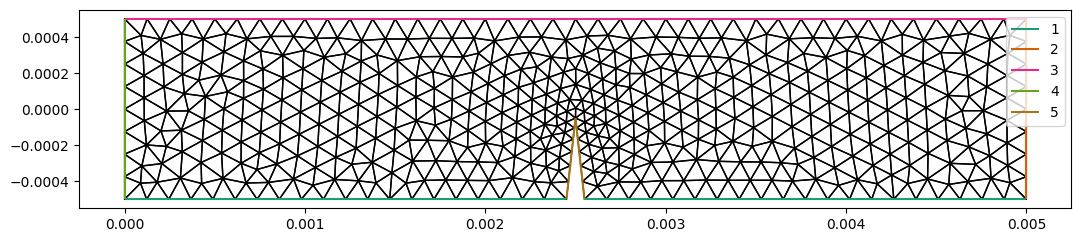

In [ ]:
mesh = Mesh(meshPath + 'cp3ChipNotchMeshFile.msh')

fig, axes = plt.subplots(figsize=[12.8,5])
triplot(mesh, axes=axes)
axes.legend(loc="upper right")
axes.set_aspect('equal')

First we need to solve the temperature field and then displacement field. Refer to this example for help in setting thermoelasticity problem ([example](https://comet-fenics.readthedocs.io/en/latest/demo/thermoelasticity/thermoelasticity.html)). Remember this example is for a single material property.

In [ ]:
# Choose function space for temperature
if elementType == 1:
  VT = FunctionSpace(mesh, "P", elementOrder)
elif elementType == 2:
  VT = FunctionSpace(mesh, "Q", elementOrder)

In [ ]:
# Test and trial function for temperature
T_test = TestFunction(VT)
T_trial = TrialFunction(VT)

For defining the material property at different locations of the domain use the firedrake [interpolate](https://www.firedrakeproject.org/interpolation.html) function with [conditional operator](https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html). Using the conditional operator we can assign thermal properties based on location of a point (analogous to C++ conditional statement).

In [ ]:
# Material properties
#--------------Complete the following lines of code----------------------
k_top = 148.0
k_bottom = 10.0
alpha_top = 2.6e-6
alpha_bottom = 95e-6
lambda_top = 256e9
lambda_bottom = 12e9
mu_top = 64e9
mu_bottom = 1e9

In [ ]:
x = SpatialCoordinate(VT.mesh())
x2 = x[1]
bound_line = Constant(0)
k_val = conditional(x2>0, k_top, k_bottom);
k = Function(VT); k.interpolate(k_val)
alpha_val = conditional(x2>0, alpha_top, alpha_bottom);#conditional(ge(real(x2-bound_line), alpha_top), x2-bound_line, alpha_bottom)
alpha = Function(VT); alpha.interpolate(alpha_val)
lamda_val = conditional(x2>0, lambda_top, lambda_bottom);#conditional(ge(real(x2-bound_line), lambda_top), x2-bound_line, lambda_bottom)
lamda = Function(VT); lamda.interpolate(lamda_val)
mu_val = conditional(x2>0, mu_top, mu_bottom);#conditional(ge(real(x2-bound_line), mu_top), x2-bound_line, mu_bottom)
mu = Function(VT); mu.interpolate(mu_val)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7adecc584f10>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 451)), 908)

In [414]:
#--------------Complete the following lines of code----------------------
# Boundary parameters for temperature
T_sub = 293.0
heat_flux = 50e3 + 20e6 * x[0]

In [415]:
#--------------Complete the following lines of code----------------------
# Variational equation for temperature
aT = k_val * dot(grad(T_trial), grad(T_test)) * dx
LT = heat_flux * T_test * ds(3)

In [ ]:
#--------------Complete the following lines of code----------------------
# Dirichilet boundary condition at y = -0.5 mm
bcT = DirichletBC(VT, T_sub, 1)

In [ ]:
# Create a function to store the solution
T_soln = Function(VT)

In [ ]:
# Solve for temperature
solve(aT == LT, T_soln, bcs = bcT, solver_parameters={'ksp_type': 'gmres'})

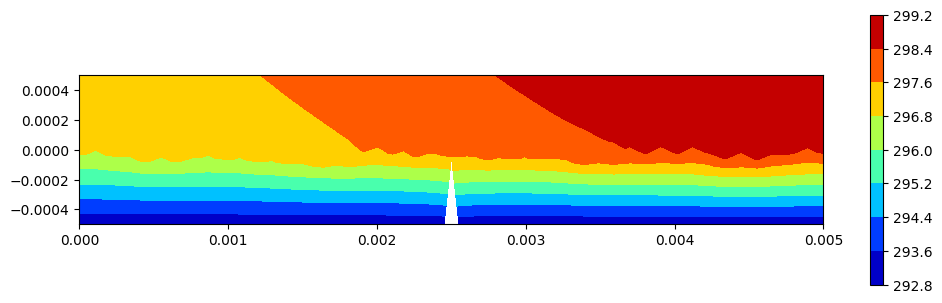

In [ ]:
fig, axes = plt.subplots(figsize=[12,3.5])
contours = tricontourf(T_soln, axes=axes, cmap='jet')
fig.colorbar(contours)
axes.set_aspect('equal')

Create functions for stress and strain similar to the thermoelasiticy example.

In [ ]:
# Identity matrix
Id = Identity(mesh.geometric_dimension())
#--------------Complete the following lines of code----------------------
# strain tensor function
def epsilon(u, Temp, alpha):
  """
  Calculates the strain
  Args:
    u: displacement
    Temp: Temperature
    alpha: expansion coefficient
  Returns:
    epsilon: strain
  """
  return 0.5 * (grad(u) + grad(u).T) - alpha * Id * (Temp - T_sub)

In [ ]:
#--------------Complete the following lines of code----------------------
# stress tensor
def sigma(u, Temp, alpha):
  """
  Calculates the stress
  Args:
    u: displacement
    Temp: Temperature
    alpha: expansion coefficient
  Returns:
    sigma: stress
  """
  return lamda * tr(epsilon(u, Temp, alpha)) * Id + 2 * mu * epsilon(u, Temp, alpha)

In [ ]:
#--------------Complete the following lines of code----------------------
# von Misses stress function
def von_mises_stress(u, Temp, alpha):
  """
  Calculates the von Mises stress
  Args:
    u: displacement
    Temp: Temperature
    alpha: expansion coefficient
  Returns:
    von_mises: von Mises stress
  """
  s = sigma(u, Temp, alpha)
  dev_s = s - (1.0/3.0) * tr(s) * Id  # deviatoric stress
  return sqrt(3.0/2.0 * inner(dev_s, dev_s))

In [ ]:
# Vector function space for displacement
if elementType == 1:
  V = VectorFunctionSpace(mesh, "P", elementOrder)
elif elementType == 2:
  V = VectorFunctionSpace(mesh, "Q", elementOrder)

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)

In [ ]:
#--------------Complete the following lines of code----------------------
# Variational equation for elasticity
a = lhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx)
L = rhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx) + inner(Constant((0.0, 0.0)), v) * (ds(1) + ds(2) + ds(3))

In [ ]:
#--------------Complete the following lines of code----------------------
# Dirichilet BC for displacement
bcu = DirichletBC(V, Constant((0.0, 0.0)), 4)

In [ ]:
u_soln = Function(V)

In [ ]:
# Solve for displacement
solve(a==L, u_soln, bcs = bcu)

In [ ]:
# interpolate the solutions into the FE spaces
# Temperatures
T_soln_interp = interpolate(T_soln, VT)
# displacements
u_soln_interp = interpolate(u_soln, V)

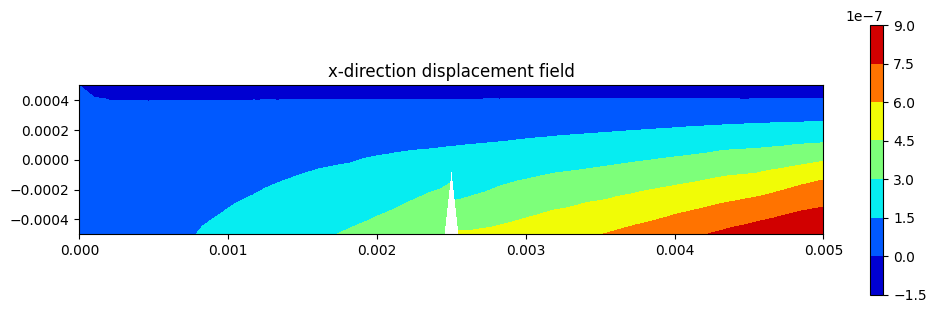

In [ ]:
# plot the y-component of the displacement field
fig, axes = plt.subplots(figsize=[12,3.5])
u_sol_x = u_soln.sub(0)
contours = tricontourf(u_sol_x, axes=axes, cmap='jet')
axes.set_title('x-direction displacement field')
fig.colorbar(contours)
axes.set_aspect('equal')

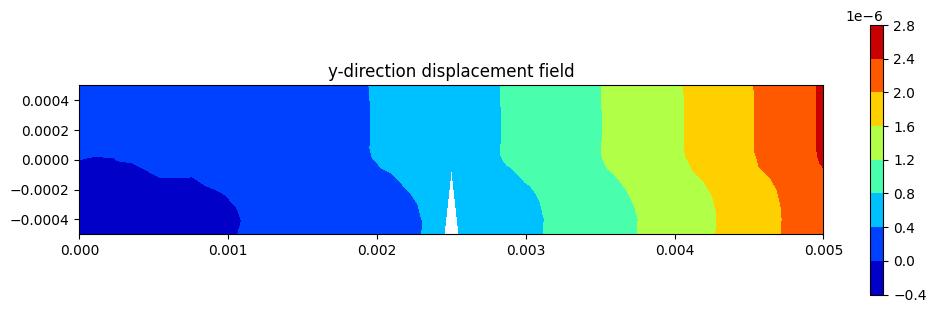

In [ ]:
# plot the y-component of the displacement field
fig, axes = plt.subplots(figsize=[12,3.5])
u_sol_y = u_soln.sub(1)
contours = tricontourf(u_sol_y, axes=axes, cmap='jet')
axes.set_title('y-direction displacement field')
fig.colorbar(contours)
axes.set_aspect('equal')

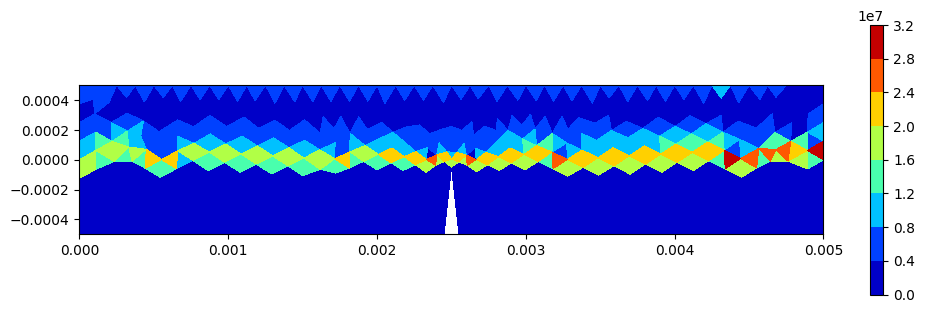

In [ ]:
# plot von-Misess stresses
von_mises = von_mises_stress(u_soln, T_soln, alpha)
# projec the space in a P0 discontinous space
V_stress = FunctionSpace(mesh, "DG", 0)
# Ensure von_mises is projected onto the same function space as von_mises_function
von_mises_projected = project(von_mises, V_stress)
von_mises_function = Function(V_stress)
von_mises_function.interpolate(von_mises_projected)
# plot von Mises stresses
fig, axes = plt.subplots(figsize=[12,3.5])
contours = tricontourf(von_mises_function, axes=axes, cmap='jet')
fig.colorbar(contours)
axes.set_aspect('equal')

## Visualizing results
For visualizing the results, we can export the output from Firedrake as VTK files to be read by ParaView for visualization. Here is the link to exporting data from Firedrake as VTK file ([visualization](https://www.firedrakeproject.org/visualisation.html))

In [ ]:
from firedrake.output import VTKFile

In [ ]:
# Save data as VTK files
temperature = VTKFile("temperature.pvd")
displacements= VTKFile("displacements.pvd")
von_mises_stress = VTKFile("von_mises_stress.pvd")
temperature.write(T_soln)
displacements.write(u_soln)
von_mises_stress.write(von_mises_function)


See the deformed configuration

In [ ]:
# Deformed mesh
# ~ store the undeformed mesh for comparing
mesh_init = Mesh(meshPath + 'cp3ChipNotchMeshFile.msh')
# ~ store a copy of the undeformed mesh to not override it
deformed_mesh = Mesh(meshPath + 'cp3ChipNotchMeshFile.msh')

# ~ create a FE space to project displacements and use them to deform the mesh
if elementType == 1:
  V_deformed = VectorFunctionSpace(deformed_mesh, "CG", elementOrder)
elif elementType == 2:
  V_deformed = VectorFunctionSpace(deformed_mesh, "Lagrange", elementOrder)

# ~ define the magnification factor
amp_mag = 1000

# Get coordinates of the nodes of the deformed mesh
coordinates = deformed_mesh.coordinates.dat.data_ro

# Evaluate u_soln at the coordinates of the deformed mesh
u_soln_values = u_soln.at(coordinates)

# Convert u_soln_values to a NumPy array
import numpy as np
u_soln_values = np.array(u_soln_values)

# Calculate the displaced coordinates (magnified by amp_mag)
displaced_coordinates = coordinates + u_soln_values * amp_mag

# Update the mesh coordinates to their deformed positions
deformed_mesh.coordinates.dat.data[:] = displaced_coordinates

In [ ]:
print(T_soln.at([0.0025, -0.00025]))
print(u_soln.at([0.0025, -0.00025]))

295.63523194664356
[3.22581895e-07 4.84440537e-07]


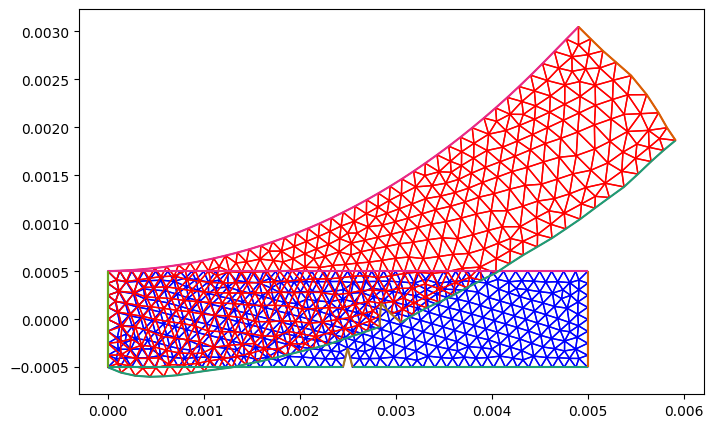

In [ ]:
fig, axes = plt.subplots(figsize=[12,5])
triplot(mesh_init, axes=axes, interior_kw={"edgecolors":"blue"})
triplot(deformed_mesh, axes=axes, interior_kw={"edgecolors":"red"})
axes.set_aspect('equal')